In [2]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import model

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt


In [3]:
plt.rc('figure', figsize=(13, 6))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

In [4]:
# Read in the data - Global Land Temperature by City
df = pd.read_csv('GLC.csv',index_col=0)

In [5]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [6]:
# Select the specific location data
austin_df = df[(df["City"] == "Austin")]

In [7]:
austin_df

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1820-01-01,7.169,3.676,Austin,United States,29.74N,97.85W
1820-02-01,11.448,2.964,Austin,United States,29.74N,97.85W
1820-03-01,15.003,2.413,Austin,United States,29.74N,97.85W
1820-04-01,21.022,2.136,Austin,United States,29.74N,97.85W
1820-05-01,23.938,1.923,Austin,United States,29.74N,97.85W
...,...,...,...,...,...,...
2013-05-01,23.617,0.217,Austin,United States,29.74N,97.85W
2013-06-01,28.652,0.537,Austin,United States,29.74N,97.85W
2013-07-01,28.946,0.329,Austin,United States,29.74N,97.85W


In [8]:
# Rename some columns
austin_df.rename(columns={'AverageTemperature':'average_temp', 'City':'city', 'Country':'country'}, inplace=True)

In [9]:
# Drop unneccesary columns in order to concentrate on what's needed for this exercise.
austin_df = austin_df.drop(['AverageTemperatureUncertainty', 'Latitude', 'Longitude'], axis=1)

In [10]:
# Check for nulls
austin_df.isnull().sum()

average_temp    9
city            0
country         0
dtype: int64

In [11]:
# Since the amount of nulls is minimal, go ahead and drop them
austin_df = austin_df.dropna()

In [12]:
austin_df.isnull().sum()

average_temp    0
city            0
country         0
dtype: int64

In [13]:
austin_df.shape

(2316, 3)

In [14]:
austin_df

,average_temp,city,country
dt,,,
1820-01-01,7.169,Austin,United States
1820-02-01,11.448,Austin,United States
1820-03-01,15.003,Austin,United States
1820-04-01,21.022,Austin,United States
1820-05-01,23.938,Austin,United States
...,...,...,...
2013-05-01,23.617,Austin,United States
2013-06-01,28.652,Austin,United States
2013-07-01,28.946,Austin,United States


In [15]:
austin_df.index = pd.to_datetime(austin_df.index)


In [16]:
austin_df_r = austin_df.resample('M')[['average_temp']].mean()

Text(0, 0.5, 'Temperature in Celsius')

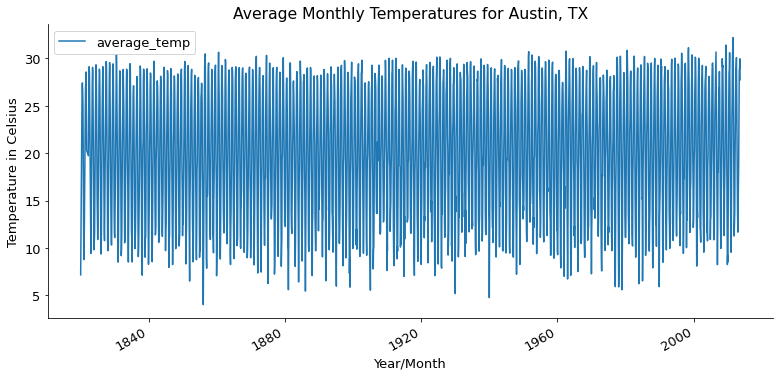

In [17]:
# Initial plot to see if there's any trend - looks to be a slight upward trend towards the end
austin_df.plot()
plt.title('Average Monthly Temperatures for Austin, TX')
plt.xlabel('Year/Month')
plt.ylabel('Temperature in Celsius')

In [18]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [19]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    plt.ylabel('Average Temperature in Celsius')
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()

In [20]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [21]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [22]:
# set train size to be 50% of total 
train_size = int(len(austin_df) * 0.5)
train_size

1158

In [23]:
# set validate size to be 30% of total 
validate_size = int(len(austin_df) * 0.3)
validate_size

694

In [24]:
# set test size to be number of rows remaining. 
test_size = int(len(austin_df) - train_size - validate_size)
test_size

464

In [25]:
validate_end_index = train_size + validate_size
validate_end_index

1852

In [26]:

train = austin_df[:train_size]

validate = austin_df[train_size:validate_end_index]

test = austin_df[validate_end_index:]

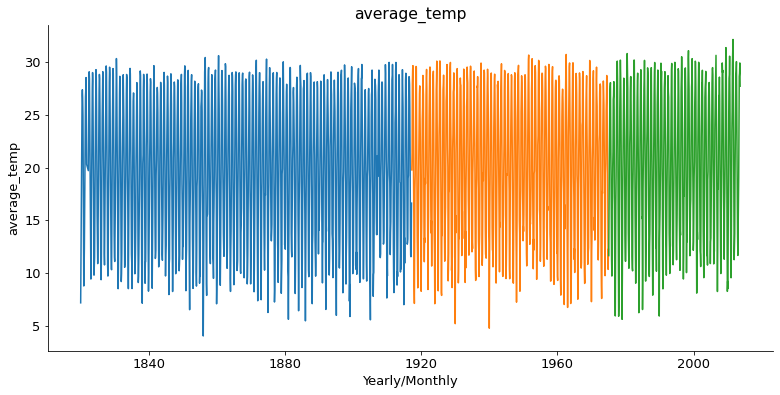

In [27]:
plt.plot(train['average_temp'])
plt.plot(validate['average_temp'])
plt.plot(test['average_temp'])
plt.xlabel('Yearly/Monthly')
plt.ylabel('average_temp')
plt.title('average_temp')
plt.show()

### Last observed value

In [28]:
# take the last item of dollars sold and assign to variable
temp = round(train['average_temp'][-1:][0], 2)
temp

16.63

In [29]:
yhat_df = pd.DataFrame({'average_temp': [temp]},
                      index = validate.index)


In [30]:
yhat_df.head()

,average_temp
dt,
1917-04-01,16.63
1917-05-01,16.63
1917-06-01,16.63
1917-07-01,16.63
1917-08-01,16.63


average_temp -- RMSE: 8.0000


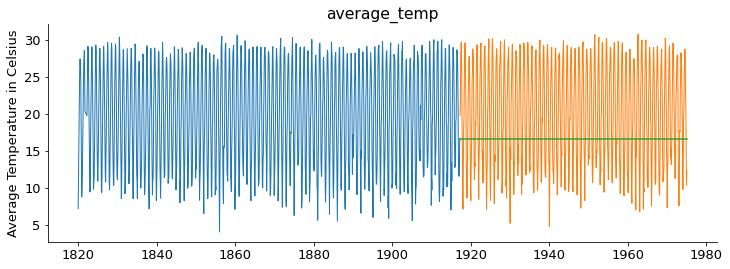

In [31]:
plot_and_eval('average_temp')

In [32]:
eval_df = append_eval_df('last_observed', 'average_temp')
eval_df

,model_type,target_var,rmse
0,last_observed,average_temp,8.0


### Simple Average

In [33]:
# compute simple average
ave_temp = round(train['average_temp'].mean(), 2)
ave_temp

19.7

In [78]:
yhat_df = pd.DataFrame({'average_temp': [ave_temp]}, 
                      index = validate.index)

yhat_df.head()

,average_temp
dt,
1917-12-31,19.73
1918-12-31,19.73
1919-12-31,19.73
1920-12-31,19.73
1921-12-31,19.73


In [79]:
yhat_df

,average_temp
dt,
1917-12-31,19.73
1918-12-31,19.73
1919-12-31,19.73
1920-12-31,19.73
1921-12-31,19.73
1922-12-31,19.73
1923-12-31,19.73
1924-12-31,19.73
1925-12-31,19.73


average_temp -- RMSE: 7.0000


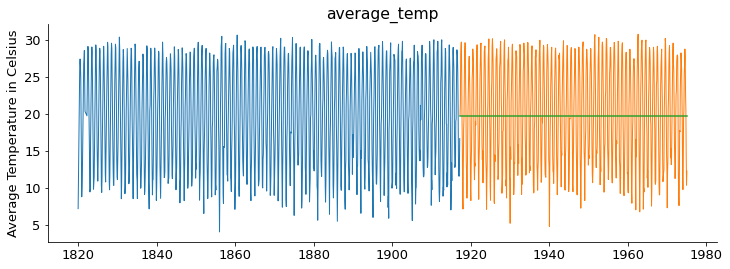

In [35]:
plot_and_eval('average_temp')

In [36]:
eval_df = append_eval_df(model_type='simple_average', 
                            target_var = 'average_temp')
eval_df

,model_type,target_var,rmse
0,last_observed,average_temp,8.0
1,simple_average,average_temp,7.0


### Moving Average

In [37]:
# 30 day moving average
period = 30 

# take 30 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
ave_temp = round(train['average_temp'].rolling(period).mean()[-1], 2)
print(ave_temp)

18.92


average_temp -- RMSE: 7.0000


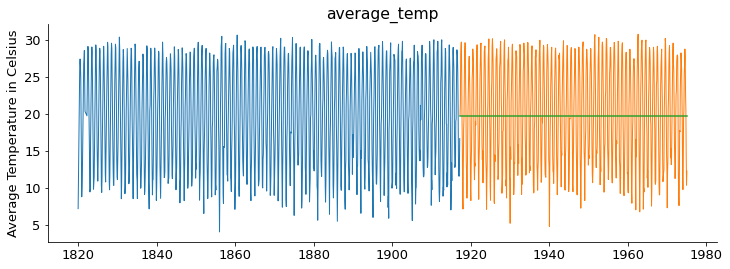

In [38]:
plot_and_eval('average_temp')

In [39]:
eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = 'average_temp')

eval_df

,model_type,target_var,rmse
0,last_observed,average_temp,8.0
1,simple_average,average_temp,7.0
2,30d_moving_avg,average_temp,7.0


In [40]:
def make_predictions():
    yhat_df = pd.DataFrame({'average_temp': [ave_temp]},
                          index=validate.index)
    return yhat_df

In [41]:
periods = [4, 12, 26, 52, 104]

# Let's try out several other values for periods:
for period in periods: 
    ave_temp = round(train['average_temp'].rolling(period).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(period) + 'd_moving_avg'
    eval_df = append_eval_df(model_type = model_type, 
                                 target_var = 'average_temp')

In [42]:
eval_df

,model_type,target_var,rmse
0,last_observed,average_temp,8.0
1,simple_average,average_temp,7.0
2,30d_moving_avg,average_temp,7.0
3,4d_moving_avg,average_temp,10.0
4,12d_moving_avg,average_temp,7.0
5,26d_moving_avg,average_temp,7.0
6,52d_moving_avg,average_temp,7.0
7,104d_moving_avg,average_temp,7.0


In [43]:
# What is the best so far?
min_ave_temp_rmse = eval_df[eval_df.target_var == 'average_temp']['rmse'].min()

eval_df[eval_df.rmse == min_ave_temp_rmse]

,model_type,target_var,rmse
1,simple_average,average_temp,7.0
2,30d_moving_avg,average_temp,7.0
4,12d_moving_avg,average_temp,7.0
5,26d_moving_avg,average_temp,7.0
6,52d_moving_avg,average_temp,7.0
7,104d_moving_avg,average_temp,7.0


In [44]:
train

,average_temp,city,country
dt,,,
1820-01-01,7.169,Austin,United States
1820-02-01,11.448,Austin,United States
1820-03-01,15.003,Austin,United States
1820-04-01,21.022,Austin,United States
1820-05-01,23.938,Austin,United States
...,...,...,...
1916-11-01,14.249,Austin,United States
1916-12-01,11.692,Austin,United States
1917-01-01,11.545,Austin,United States


### Holt's Linear Trend

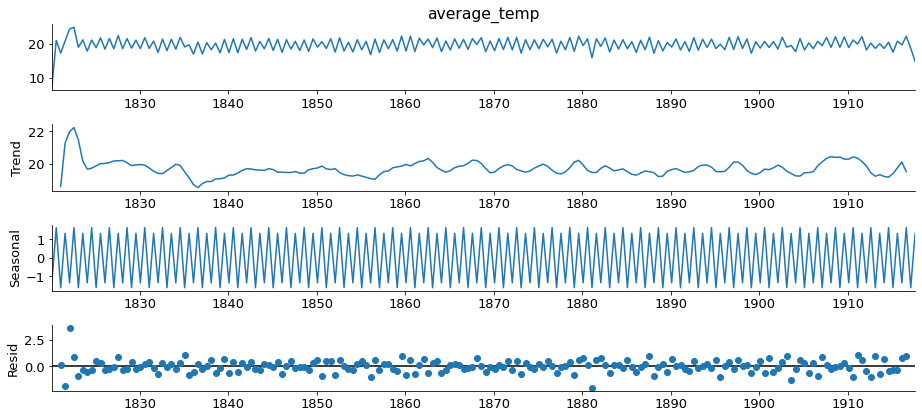

In [45]:
sm.tsa.seasonal_decompose(train['average_temp'].resample('6M').mean()).plot()
plt.show()


In [46]:
train.isnull().sum()

average_temp    0
city            0
country         0
dtype: int64

In [47]:
train.index = pd.to_datetime(train.index)

In [54]:
train = train.resample('Y')[['average_temp']].mean()

In [50]:
validate.index = pd.to_datetime(validate.index)

In [55]:
validate = validate.resample('Y')[['average_temp']].mean()

In [56]:
train.head()

,average_temp
dt,
1820-12-31,14.054750
1821-12-31,18.978167
1822-12-31,24.519333
1823-12-31,20.016750
1824-12-31,19.419917


In [62]:
col = 'average_temp'
# create the Holt object 
model = Holt(train[col], exponential=False, damped=True)
# fit the model 
model = model.fit(optimized=True)
# make predictions for each date in validate 
yhat_items = model.predict(start = validate.index[0],
                           end = validate.index[-1])
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 4)

In [63]:
validate.index[0]

Timestamp('1917-12-31 00:00:00', freq='A-DEC')

In [82]:
model = Holt(train['average_temp'], exponential = False)
model = model.fit(smoothing_level = .1, 
                    smoothing_slope = .1, 
                    optimized = False)
yhat_items = model.predict(start = validate.index[0], 
                            end = validate.index[-1])

yhat_df['average_temp'] = yhat_items


In [83]:
yhat_df

,average_temp
dt,
1917-12-31,20.177554
1918-12-31,19.806056
1919-12-31,19.780829
1920-12-31,19.755602
1921-12-31,19.730375
1922-12-31,19.705149
1923-12-31,19.679922
1924-12-31,19.654695
1925-12-31,19.629468


average_temp -- RMSE: 1.0000


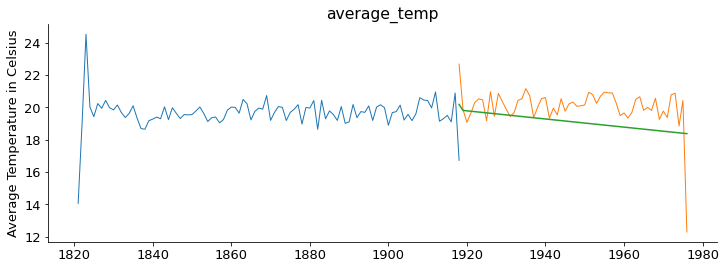

In [84]:
plot_and_eval('average_temp')

In [85]:
eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = 'average_temp')

In [86]:
eval_df

,model_type,target_var,rmse
0,last_observed,average_temp,8.0
1,simple_average,average_temp,7.0
2,30d_moving_avg,average_temp,7.0
3,4d_moving_avg,average_temp,10.0
4,12d_moving_avg,average_temp,7.0
5,26d_moving_avg,average_temp,7.0
6,52d_moving_avg,average_temp,7.0
7,104d_moving_avg,average_temp,7.0
8,holts_optimized,average_temp,1.0


In [87]:
# Change some hyper-parameters
model = Holt(train['average_temp'], exponential=False)
model = model.fit(smoothing_level=0.1,
                      smoothing_slope=0.1,
                      optimized=False)
yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
yhat_df['average_temp'] = round(yhat_items, 2)

average_temp -- RMSE: 1.0000


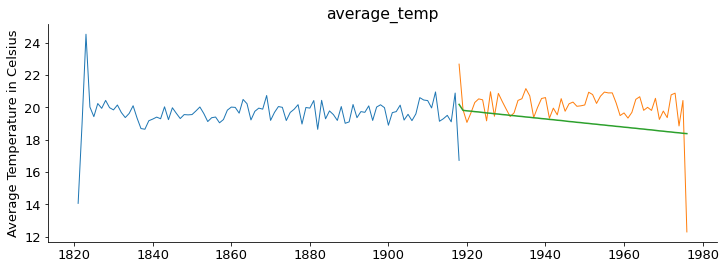

In [88]:
plot_and_eval('average_temp')

In [89]:
eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = 'average_temp')

In [90]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
8,holts_optimized,average_temp,1.0
9,holts_.1,average_temp,1.0
1,simple_average,average_temp,7.0
2,30d_moving_avg,average_temp,7.0
4,12d_moving_avg,average_temp,7.0
5,26d_moving_avg,average_temp,7.0
6,52d_moving_avg,average_temp,7.0
7,104d_moving_avg,average_temp,7.0
0,last_observed,average_temp,8.0
3,4d_moving_avg,average_temp,10.0
